# 1. Crawl the dataset

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
import seaborn as sns
sns.set()

In [4]:
# Vietnam stock information crawling
# https://github.com/thinh-vu/vnstock

!pip install vnstock

from vnstock import *### Split the dataset into time windows to get data samples.  

compdata_list = []

vnindex30 = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 
             'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'POW', 'SAB', 'SSI', 'STB', 
             'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

for comp in vnindex30:
    comp_data = stock_historical_data(comp, "2005-01-01", "2023-05-24")   
    compdata_list.append(comp_data)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
comp = compdata_list[0].copy()
comp

,Open,High,Low,Close,Volume,TradingDate
0,5050.0,8234.0,6532.0,7147.0,56500,2006-11-21
1,6038.0,7861.0,7136.0,7394.0,62300,2006-11-22
2,6093.0,7959.0,7136.0,7597.0,69900,2006-11-23
3,5928.0,8344.0,7685.0,8058.0,63600,2006-11-24
4,6203.0,8860.0,7410.0,8058.0,42400,2006-11-27
...,...,...,...,...,...,...
4105,24900.0,25100.0,24850.0,25000.0,3353042,2023-05-18
4106,25050.0,25050.0,24750.0,24950.0,4008117,2023-05-19
4107,25000.0,25050.0,24900.0,25050.0,4585906,2023-05-22
4108,25200.0,25600.0,25000.0,25350.0,21726379,2023-05-23


# 2. Trading point prediction using LSTM

In [6]:
window = 30

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
 
data = comp.iloc[:, :4]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

In [8]:
data['difference'] = data['Close'] - data['Open']

In [9]:
# Define thresholds for price change
buy_threshold = 0.01
sell_threshold = -0.01

# Generate labels based on price change
price_change = data['Close'].pct_change()
labels = np.zeros_like(price_change)
labels[price_change > buy_threshold] = 1  # Buy
labels[price_change < sell_threshold] = -1  # Sell

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(window, 4)))
model.add(Dense(3, activation='softmax'))  
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])

In [11]:
# Prepare the training data
X_train = []
y_train = []
X_val = []
y_val = []

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i, 0:])
    y_train.append(labels[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [12]:
data

,Open,High,Low,Close,difference
0,5050.0,8234.0,6532.0,7147.0,2097.0
1,6038.0,7861.0,7136.0,7394.0,1356.0
2,6093.0,7959.0,7136.0,7597.0,1504.0
3,5928.0,8344.0,7685.0,8058.0,2130.0
4,6203.0,8860.0,7410.0,8058.0,1855.0
...,...,...,...,...,...
4105,24900.0,25100.0,24850.0,25000.0,100.0
4106,25050.0,25050.0,24750.0,24950.0,-100.0
4107,25000.0,25050.0,24900.0,25050.0,50.0
4108,25200.0,25600.0,25000.0,25350.0,150.0


In [13]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10, batch_size=512)

Epoch 1/10
6/6 [==============================] - 5s 328ms/step - loss: 0.5385 - mse: 0.5385 - val_loss: 0.5540 - val_mse: 0.5540
Epoch 2/10
6/6 [==============================] - 1s 127ms/step - loss: 0.5381 - mse: 0.5381 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 3/10
6/6 [==============================] - 1s 118ms/step - loss: 0.5381 - mse: 0.5381 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 4/10
6/6 [==============================] - 1s 168ms/step - loss: 0.5381 - mse: 0.5381 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 5/10
6/6 [==============================] - 1s 183ms/step - loss: 0.5381 - mse: 0.5381 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 6/10
6/6 [==============================] - 1s 220ms/step - loss: 0.5381 - mse: 0.5381 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 7/10
6/6 [==============================] - 1s 238ms/step - loss: 0.5381 - mse: 0.5381 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 8/10
6/6 [==============================] - 1s 244ms/step - loss: 0.5381 - mse: 0.53

In [14]:
# Prepare the testing data
X_test = []
y_test = []

for i in range(window, len(test_data)):
    X_test.append(test_data[i-window:i, 0:])
    y_test.append(labels[i])

X_test, y_test = np.array(X_test), np.array(y_test)

# Evaluate the model
y_pred = model.predict(X_test)
# print("MSE on the test set: ", mean_squared_error(y_pred, y_test))


25/25 [==============================] - 2s 22ms/step


In [15]:
for i in range(len(y_pred)):
  if (max(y_pred[i]) == y_pred[i][0]):
    y_pred[i] = -1
  elif (max(y_pred[i] == y_pred[i][1])):
    y_pred[i] = 0
  else:
    y_pred[i] = 1

In [16]:
y_pred[4]

array([0., 0., 0.], dtype=float32)

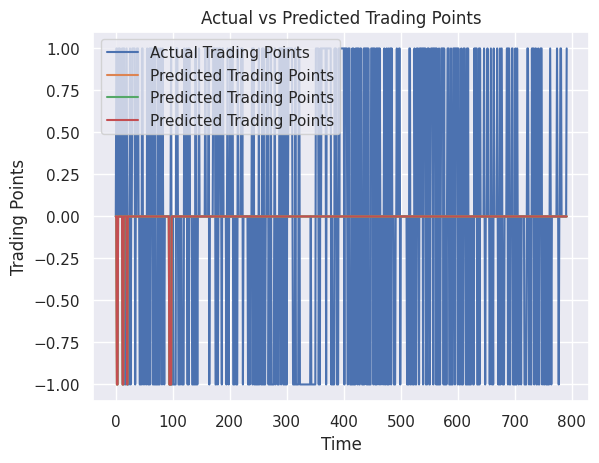

In [17]:
import matplotlib.pyplot as plt

# Plotting the actual trading points
plt.plot(y_test, label='Actual Trading Points')

# Plotting the predicted trading points
plt.plot(y_pred, label='Predicted Trading Points')

plt.xlabel('Time')
plt.ylabel('Trading Points')
plt.title('Actual vs Predicted Trading Points')
plt.legend()
plt.show()


# 3. Using crossover between different SMAs

In [18]:
import numpy as np

comp['50days'] = comp["Close"].rolling(50).mean()
comp['200days'] = comp["Close"].rolling(200).mean()

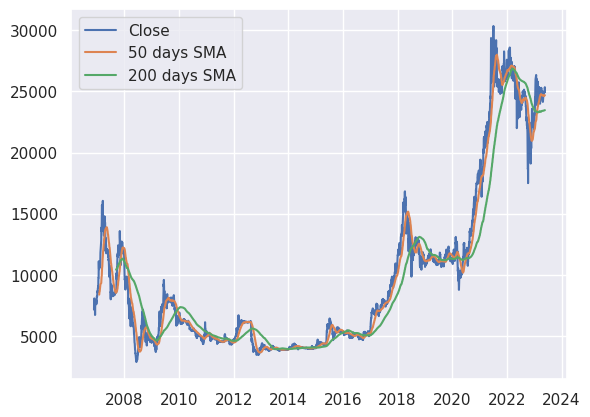

In [19]:
plt.plot(comp['TradingDate'], comp['Close'], label = 'Close')
plt.plot(comp['TradingDate'], comp['50days'], label = '50 days SMA')
plt.plot(comp['TradingDate'], comp['200days'], label = '200 days SMA')
plt.legend()
plt.show()

In [20]:
comp['signal'] = 0
comp['signal'][50:] = np.where(comp['50days'][50:] 
                                            > comp['200days'][50:], 1.0, 0.0)   
comp['positions'] = comp['signal'].diff()

<ipython-input-20-8393b36c4435>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp['signal'][50:] = np.where(comp['50days'][50:]


In [21]:
comp[200:]

,Open,High,Low,Close,Volume,TradingDate,50days,200days,signal,positions
200,8575.0,8575.0,8539.0,8560.0,86300,2007-09-13,8542.68,10430.115,0,0.0
201,8646.0,8696.0,8582.0,8660.0,88100,2007-09-14,8545.10,10436.445,0,0.0
202,8646.0,9090.0,8716.0,8961.0,227200,2007-09-17,8552.40,10443.265,0,0.0
203,9003.0,10474.0,9740.0,9639.0,351400,2007-09-18,8573.68,10451.170,0,0.0
204,10004.0,10225.0,9761.0,10140.0,413600,2007-09-19,8593.56,10461.580,0,0.0
...,...,...,...,...,...,...,...,...,...,...
4105,24900.0,25100.0,24850.0,25000.0,3353042,2023-05-18,24678.00,23463.000,1,0.0
4106,25050.0,25050.0,24750.0,24950.0,4008117,2023-05-19,24687.00,23465.500,1,0.0
4107,25000.0,25050.0,24900.0,25050.0,4585906,2023-05-22,24688.00,23467.750,1,0.0
4108,25200.0,25600.0,25000.0,25350.0,21726379,2023-05-23,24688.00,23469.500,1,0.0


In [25]:
### Reference: https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/agent/2.moving-average-agent.ipynb
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(comp))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [26]:
states_buy, states_sell, total_gains, invest = buy_stock(comp.Close, comp['positions'])

day 244: total balances 10000.000000, not enough money to buy a unit price 12155.000000
day 307: cannot sell anything, inventory 0
day 602: buy 1 units at price 6136.000000, total balance 3864.000000
day 761, sell 1 units at price 5968.000000, investment -2.737940 %, total balance 9832.000000,
day 1052: buy 1 units at price 5000.000000, total balance 4832.000000
day 1062, sell 1 units at price 4601.000000, investment -7.980000 %, total balance 9433.000000,
day 1229: buy 1 units at price 4679.000000, total balance 4754.000000
day 1239, sell 1 units at price 4311.000000, investment -7.864928 %, total balance 9065.000000,
day 1294: buy 1 units at price 5324.000000, total balance 3741.000000
day 1449, sell 1 units at price 4345.000000, investment -18.388430 %, total balance 8086.000000,
day 1632: buy 1 units at price 4059.000000, total balance 4027.000000
day 1688, sell 1 units at price 3810.000000, investment -6.134516 %, total balance 7837.000000,
day 1791: buy 1 units at price 4034.0000

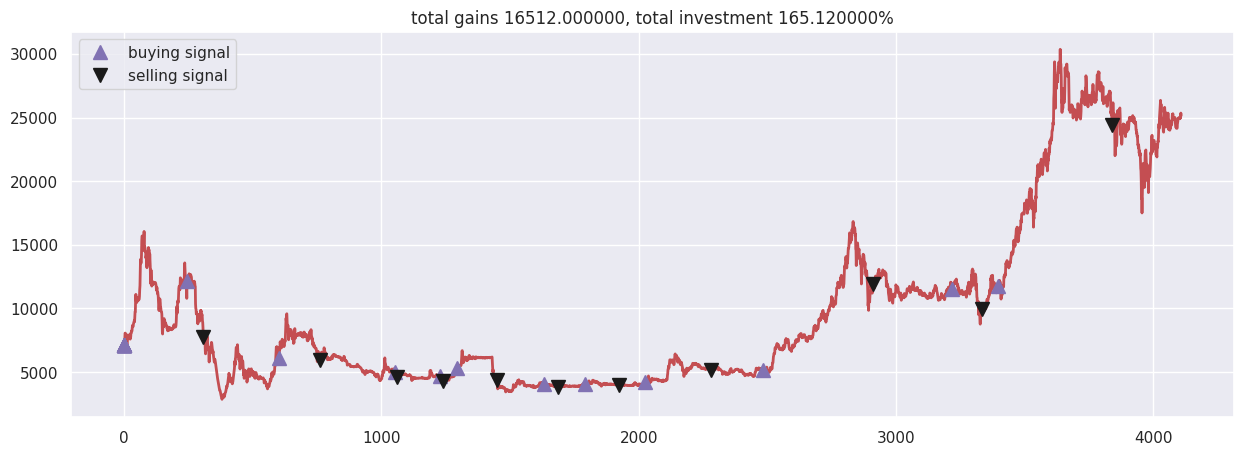

In [27]:
close = comp['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()